# Performance

In [1]:
import sys
sys.path.insert(0, 'D:/work/Personal/ml_project_2_deep_hedging/src')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import norm
from simulation import *
from env import StockTradingEnv
from agent import DDPG_Hedger
from paths import DATA_ROOT
from network import MLP

d:\work\Personal\ml_project_2_deep_hedging\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate data and appply classical hedging

*Please save these parameters to reproduce the plots included in the report*

In [84]:
T = 60 # length of simulation 20= 1 month, 60 = 3 months
S0 = 100 # starting price
K = 100 # strike price
sigma = 0.2 # volatility
r = 0 # risk-free rate
q = 0 # dividend yield
mu = 0.05 # expected return on stock
kappa = 0.01 # trading cost per unit traded
dt = 1 # hedging time step
notional = 100 # how many stocks the option is on
rho = -0.4 # correlation of stochastic volatility process
v = 0.6
sigma0 = 0.2 # starting volatility
c = 1.5 #standard deviation coefficient
ds = 0.01

n = 3000 # number of simulatied paths
days = 250 # number of days in a year
freq = 1 # trading frequency 
np.random.seed(12)   # seed = 12 to get same plots as in report

- 1st run: save train data
- 2nd run or more: ignore this process and import data and run afterwards.

In [85]:
S_gbm, p_gbm, d_gbm = simulateGBM(n, T, dt, S0, mu, r, q, sigma, days, freq, K)

S_sabr, s_sabr, iv_sabr, p_sabr, delta_sabr, delta_sabr_bl = simulateSABR(
    n, T, dt, S0, mu, r, q, sigma, days, freq, rho, ds, v, K)

100%|██████████| 59/59 [00:00<00:00, 4933.29it/s]
D:\work/Personal/ml_project_2_deep_hedging/src\simulation.py:124: RuntimeWarning: invalid value encountered in divide
  imp_vol = np.where(f == K, atm, atm * xi / xi_func)


In [86]:
# classical hedging implementations (trading strategies)
trading_gbm, holding_gbm = hedgingStrategy("GBM",notional, d_gbm, 0)
trading_sabr, holding_sabr, trading_sabr_bl, holding_sabr_bl = hedgingStrategy("SABR",notional, delta_sabr, delta_sabr_bl)

In [87]:
# Accounting PnL
APL_gbm, holding_lagged_gbm = APL_process(S_gbm, p_gbm*notional, holding_gbm, K, notional, kappa)
APL_sabr, holding_lagged_sabr = APL_process(S_sabr, p_sabr*notional, holding_sabr, K, notional, kappa)
APL_sabr_bl, holding_lagged_sabr_bl = APL_process(S_sabr, p_sabr*notional, holding_sabr_bl, K, notional, kappa)

In [88]:
# Evaluation:
# Y(0) (take mean), 
# mean of  cost as percentage of option price,
# std of  cost as percentage of option price.

Y_gbm, mPerc_gbm, stdPerc_gbm = evaluate(APL_gbm, p_gbm, c, notional) 
Y_sabr, mPerc_sabr, stdPerc_sabr = evaluate(APL_sabr, p_sabr, c, notional)
Y_sabr_bl, mPerc_sabr_bl, stdPerc_sabr_bl = evaluate(APL_sabr_bl, p_sabr, c, notional)

In [89]:
print("GBM")
print("Y0: ", np.mean(Y_gbm))
print("mean cost (%): ", mPerc_gbm)
print("std cost (%): ", stdPerc_gbm)
print("\n")
print("SABR delta")
print("Y0: ", np.mean(Y_sabr))
print("mean cost (%): ", mPerc_sabr)
print("std cost (%): ", stdPerc_sabr)
print("\n")
print("SABR Bartlett")
print("Y0: ", np.mean(Y_sabr_bl))
print("mean cost (%): ", mPerc_sabr_bl)
print("std cost (%): ", stdPerc_sabr_bl)

GBM
Y0:  230.9829592102956
mean cost (%):  0.3080889376353497
std cost (%):  0.18871668063054245


SABR delta
Y0:  235.67621433656325
mean cost (%):  0.31010111663691714
std cost (%):  0.19538298544289592


SABR Bartlett
Y0:  235.95545018770576
mean cost (%):  0.3110807104445588
std cost (%):  0.19520636258556995


## data saving

Below code saves data in the `data` folder. You need to make sure that your
`T` and `freq` is defined well in the environment.

In [94]:
result_folder_path = DATA_ROOT + f"/{T//20}month/{freq}d"
os.makedirs(result_folder_path, exist_ok=True)

# define data
# save to csv file
np.savetxt(DATA_ROOT + f'/{T//20}month/{freq}d/asset_price_GBM_sim.csv', S_gbm, delimiter=',')
np.savetxt(DATA_ROOT + f'/{T//20}month/{freq}d/option_price_GBM_sim.csv', p_gbm*notional, delimiter=',')
np.savetxt(DATA_ROOT + f'/{T//20}month/{freq}d/asset_price_SABR_sim.csv', S_sabr, delimiter=',')
np.savetxt(DATA_ROOT + f'/{T//20}month/{freq}d/option_price_SABR_sim.csv', p_sabr*notional, delimiter=',')


S_mixed = np.vstack((S_gbm, S_sabr))
p_mixed = np.vstack((p_gbm*notional, p_sabr*notional))
print(S_mixed.shape)
print(p_mixed.shape)
np.savetxt(DATA_ROOT + f"/{T//20}month/{freq}d/asset_price_mixed_sim.csv", S_mixed, delimiter=",")
np.savetxt(DATA_ROOT + f"/{T//20}month/{freq}d/option_price_mixed_sim.csv", p_mixed, delimiter=",")

(6000, 20)
(6000, 20)


# Deep RL Method 

first cell : loading pre-trained weights into the agent 

second cell : running the experiment on the n paths (episodes)

In [90]:
data_type = "SABR"

env = StockTradingEnv(maturity=3, frequency=1, data_type=data_type, test_env=True)

# set same dataset as delta hedging
if data_type == "SABR":
    env.asset_price = S_sabr
    env.option_price = p_sabr
elif data_type == "GBM":
    env.asset_price = S_gbm
    env.option_price = p_gbm
else:
    env.asset_price = S_mixed
    env.option_price = p_mixed

nState, nAction = env.observation_space.shape[0], \
                    env.action_space.shape[0]  # 3, 1

# we use hidden layer size of 32, 64 as the author used.
actor = MLP(nState, 16, nAction, "Sigmoid")
qnet_1 = MLP(nState + nAction, 16, nAction, "")
qnet_2 = MLP(nState + nAction, 16, nAction, "")
agent = DDPG_Hedger(actor, qnet_1, qnet_2, 0, 0, 1, 32)

# model = 'v9_2nd' to obtain plots as in report
model = 'v9_2nd'
agent.load(model)

In [91]:
# below code outputs actions and stores rewards and actions
path_indice, rewards_path, action_path = [], [], []
for i in range(n):
    state = env.reset()
    env.path_idx = i
    
    path_indice.append(env.path_idx)
    rewards, actions = [], [0]
    done = False
    
    if i%1000 == 0:
        print(f'Episode {i}')
    while not done:
        normalized_state = env.normalize(state)
        
        # action without exploration
        action = agent.act(normalized_state, 0)
        
        next_state, reward, done = env.step(action)

        state = next_state
        rewards.append(np.round(reward, 2))
        actions.append(np.round(action, 2)) # each episode [0.99, 13.20 ... 100 ] shape (1,60) 
        
        if done:
            break

    # save rewards, action paths for every episode
    rewards_path.append(rewards) # <- (numEpisode=25000, 60)
    action_path.append(actions) # (numEpisode=25000, 60) = holding_gbm

Episode 0
Episode 1000
Episode 2000


## GBM

Below code calculates mean, std cost and Y(0) for GBM data.

In [73]:
# get action array as holding gbm
apl_gbm_rl, holding_lagged_rl = APL_process(S_gbm, p_gbm*notional, np.array(action_path), K, notional, kappa)
Y_gbm_rl, mPerc_gbm_rl, stdPerc_gbm_rl = evaluate(apl_gbm_rl, p_gbm, c, notional) 

print("GBM")
print("Y0: ", np.mean(Y_gbm))
print("mean cost (%): ", mPerc_gbm)
print("std cost (%): ", stdPerc_gbm)

print("GBM RL")
print("Y0: ", np.mean(Y_gbm_rl))
print("mean cost (%): ", mPerc_gbm_rl)
print("std cost (%): ", stdPerc_gbm_rl)

GBM
Y0:  10.655170994559722
mean cost (%):  -0.06702134813449519
std cost (%):  0.06286103662173377
GBM RL
Y0:  115.0326657587114
mean cost (%):  -0.12078390201830301
std cost (%):  0.2767944137440452


## SABR

Below code calculates mean, std cost and Y(0) for SABR data.

In [93]:
# get action array as holding gbm
apl_sabr_rl, holding_lagged_rl = APL_process(S_sabr, p_sabr*notional, np.array(action_path), K, notional, kappa)
Y_sabr_rl, mPerc_sabr_rl, stdPerc_sabr_rl = evaluate(apl_sabr_rl, p_sabr, c, notional) 

print("sabr")
print("Y0: ", np.mean(Y_sabr))
print("mean cost (%): ", mPerc_sabr)
print("std cost (%): ", stdPerc_sabr)

print("sabr RL")
print("Y0: ", np.mean(Y_sabr_rl))
print("mean cost (%): ", mPerc_sabr_rl)
print("std cost (%): ", stdPerc_sabr_rl)

sabr
Y0:  235.67621433656325
mean cost (%):  0.31010111663691714
std cost (%):  0.19538298544289592
sabr RL
Y0:  290.2043459783315
mean cost (%):  0.08075713995213711
std cost (%):  0.4413163271878512


# Results

## Episode Total Reward Histograms

Below plots histograms of classic delta and RL deep delta.
To show that our results are better, RL deep delta histogram should shift to the right with rewards gathered tightly.

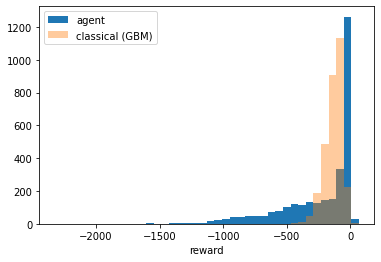

In [112]:

total_episode_rewards_gbm = APL_gbm[:,-1]
total_episode_rewards_sabr = APL_sabr[:,-1]
total_episode_rewards_sabr_bl = APL_sabr_bl[:,-1]

total_episode_rewards_agent = np.sum(np.asarray(rewards_path), axis=1)

bins=np.histogram(np.hstack((total_episode_rewards_gbm,total_episode_rewards_agent)), bins=40)[1]

plt.hist(total_episode_rewards_agent ,bins,label='agent')
plt.hist(total_episode_rewards_gbm ,bins,label='classical (GBM)', alpha=0.4)

plt.xlabel('reward')
plt.ylabel('')
plt.legend()
plt.show()



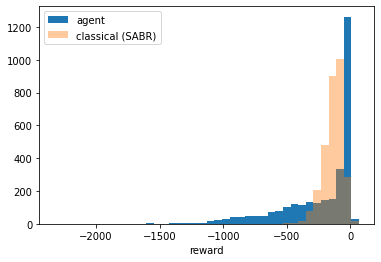

In [113]:

total_episode_rewards_gbm = APL_gbm[:,-1]
total_episode_rewards_sabr = APL_sabr[:,-1]
total_episode_rewards_sabr_bl = APL_sabr_bl[:,-1]

total_episode_rewards_agent = np.sum(np.asarray(rewards_path), axis=1)

bins=np.histogram(np.hstack((total_episode_rewards_gbm,total_episode_rewards_agent)), bins=40)[1]

plt.hist(total_episode_rewards_agent ,bins,label='agent')
plt.hist(total_episode_rewards_sabr ,bins,label='classical (SABR)', alpha=0.4)

plt.xlabel('reward')
plt.ylabel('')
plt.legend()
plt.show()

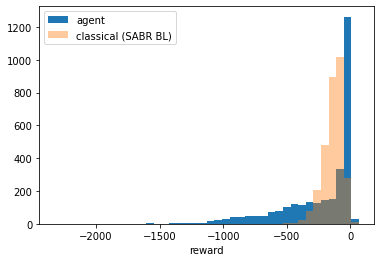

In [114]:

total_episode_rewards_gbm = APL_gbm[:,-1]
total_episode_rewards_sabr = APL_sabr[:,-1]
total_episode_rewards_sabr_bl = APL_sabr_bl[:,-1]

total_episode_rewards_agent = np.sum(np.asarray(rewards_path), axis=1)

bins=np.histogram(np.hstack((total_episode_rewards_gbm,total_episode_rewards_agent)), bins=40)[1]

plt.hist(total_episode_rewards_agent ,bins,label='agent')
plt.hist(total_episode_rewards_sabr_bl ,bins,label='classical (SABR BL)', alpha=0.4)

plt.xlabel('reward')
plt.ylabel('')
plt.legend()
plt.show()

## Action series Plot

actions undertaken by agent during a specific path (identified by idx_)

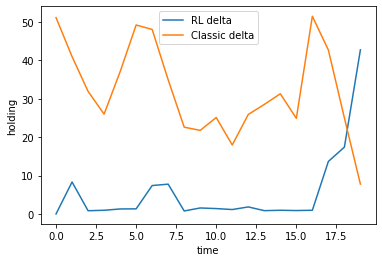

In [109]:
idx_ =  777 # idx_=777 to get same plot as in report
plt.plot(np.array(action_path)[idx_], label='RL delta')
plt.plot(holding_gbm[idx_], label='Classic delta')
plt.xlabel('time')
plt.ylabel('holding')
plt.legend()
plt.show()